In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy import ndimage

In [2]:
image_directory = './segmentation_images/'
mask_directory = './segmentation_masks/'

In [3]:
image_names = glob.glob("{image_directory}*.jpg".format(image_directory=image_directory))
mask_names = glob.glob("{mask_directory}*.jpg".format(mask_directory=mask_directory))

In [4]:
image_names.sort()
mask_names.sort()

In [5]:
def resize_images(images):
    resized_images = []
    for image in images:
        resized = cv2.resize(image,(256,256))
        resized_images.append(resized)
    return resized_images

IMG_SIZE = 256

In [6]:
def display_image(cv2_img,cv2_mask):
    cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(cv2_img)
    plt.subplot(122)
    plt.imshow(cv2_mask,cmap='grey')
    plt.show()

In [7]:
# reading images
#flag = 1 for colored image
images = [cv2.imread(img, 1) for img in image_names]
images = resize_images(images)

In [8]:
# reading masks
# flag=0 for grayscale image
masks = [cv2.imread(img,0) for img in mask_names]
masks = resize_images(masks)

In [35]:
np.unique(masks[2])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  45,  46,  47,  48,  49,  50,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  70,  72,  73,  74,  75,  77,  80,  81,  82,  83,  85,  86,
        88,  89,  90,  91,  92,  93,  94,  95,  97,  98,  99, 100, 101,
       106, 107, 108, 110, 112, 113, 115, 116, 118, 119, 121, 122, 125,
       126, 127, 128, 130, 131, 133, 134, 135, 136, 139, 140, 142, 144,
       146, 147, 148, 150, 151, 153, 154, 155, 156, 158, 159, 160, 161,
       163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 183, 184, 185, 187, 188, 191, 192, 193,
       194, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 22

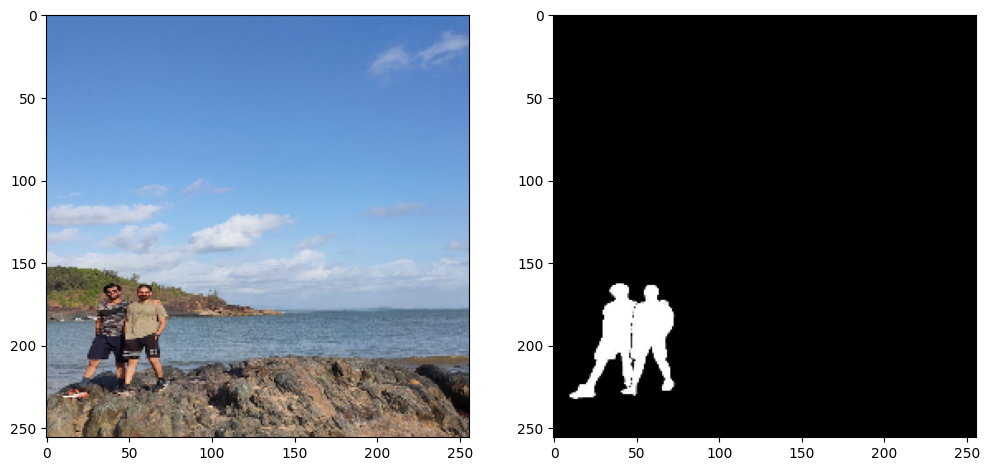

In [9]:
display_image(images[7],masks[7])

In [10]:
image_dataset = np.array(images)

In [11]:
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [12]:
image_dataset.shape, mask_dataset.shape

((66, 256, 256, 3), (66, 256, 256, 1))

In [15]:
sample_image = tf.cast(image_dataset[0], tf.float32)

In [27]:
# rng = tf.random.Generator.from_seed(123, alg='philox')
# seed = rng.make_seeds(2)[0]
# tf.image.stateless_random_crop(value=sample_image,size=(IMG_SIZE,IMG_SIZE,1),seed=seed)

In [38]:
# seed = tf.constant([1, 2], dtype=tf.int32)
# rotation_angle = tf.random.stateless_uniform(shape=[1], seed=seed, maxval=360, dtype=tf.int32)
# print(type(rotation_angle))
# rotation_angle = rotation_angle.numpy()[0]
# print(rotation_angle)

# tf.config.run_functions_eagerly(True)
# def random_rotation(image,seed):
#   op =  tf.keras.Sequential([
#   layers.RandomRotation(0.2,seed=seed)
# ])
#   ans = op(image)
#   return ans

In [17]:
# res = tf.keras.preprocessing.image.apply_affine_transform(sample_image.numpy(), theta=30, row_axis=0, col_axis=1, channel_axis=2,fill_mode='constant')
# res.shape

(256, 256, 1)

Using tf.image for preprocessing images

In [13]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [14]:
def random_rotate(image):
    # random_angle = np.random.randint(0, 181)
    return tf.keras.Sequential([layers.RandomRotation(0.2)])(image)

In [26]:
def random_rotate_scipy(image,label):
    angle = np.random.uniform(-180,180)
    image = ndimage.rotate(image,angle,reshape = False)
    label = ndimage.rotate(label,angle,reshape = False)
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    return image,label

In [16]:
def resize_and_rescale(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image

In [17]:
def augment(image_label,seed):

  image, label = image_label
  
  image = resize_and_rescale(image)
  label = resize_and_rescale(label)
  
  image = tf.image.stateless_random_crop(value=image,size=(IMG_SIZE,IMG_SIZE,3),seed=seed)
  label = tf.image.stateless_random_crop(value=label,size=(IMG_SIZE,IMG_SIZE,1),seed=seed)

  image = tf.image.stateless_random_flip_left_right(image,seed=seed)
  label = tf.image.stateless_random_flip_left_right(label,seed=seed)

  image = tf.image.stateless_random_flip_up_down(image,seed=seed)
  label = tf.image.stateless_random_flip_up_down(label,seed=seed)
  
# [-max_delta, max_delta]
  image = tf.image.stateless_random_brightness(image,max_delta=0.2,seed=seed)

# Random rotate image and label
  image,label = tf.py_function(random_rotate_scipy,inp=[image, label], Tout=(tf.float32,tf.float32))

# [1.0 - lower, 1.0 + upper]
  image = tf.image.stateless_random_contrast(image,lower=0.2,upper=0.5,seed=seed)

  return image, label

In [18]:
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x,y),seed)
  return image, label

In [19]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [27]:
train_ds = (
    train_dataset
    .shuffle(50)
    .repeat(20)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [28]:
test_ds = (
    test_dataset
    .shuffle(50)
    .repeat(20)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

def encoderBlock(input_layer,filters):
    c1 = Conv2D(filters,3,activation='relu',padding="same",input_shape=input_layer.shape)(input_layer)
    c2 = Conv2D(filters,3,activation='relu',padding="same",input_shape=input_layer.shape)(c1)
    m1 = MaxPooling2D(pool_size=2,padding='valid')(c2)
    return m1,c2

def decoderBlock(input_layer,filters,skip):
    t1 = Conv2DTranspose(filters,(2,2),strides=2, padding='valid')(input_layer)
    t1 = Concatenate()([t1,skip])
    c1 = Conv2D(filters,3,activation='relu',padding="same")(t1)
    c2 = Conv2D(filters,3,activation='relu',padding="same")(c1)
    return c2

def build_unet(input_shape,num_classes):

    Input_layer = Input(shape=input_shape)
    block1,skip1 = encoderBlock(Input_layer,64)
    block2,skip2 = encoderBlock(block1,128)
    block3,skip3 = encoderBlock(block2,256)
    block4,skip4 = encoderBlock(block3,512)

    final_encoder_block = Conv2D(1024,3,activation='relu',padding='same')(Conv2D(1024,3,activation='relu',padding='same')(block4))

    block5 = decoderBlock(final_encoder_block,512,skip4)
    block6 = decoderBlock(block5,256,skip3)
    block7 = decoderBlock(block6,128,skip2)
    block8 = decoderBlock(block7,64,skip1)

    if num_classes==1:
        activation="sigmoid"
    else:
        activation="softmax"

    output = Conv2D(filters=num_classes,kernel_size=1,activation=activation,padding='same')(block8)
    model = Model(Input_layer,output,name="U-Net")
    return model

In [24]:
input_shape = (IMG_SIZE,IMG_SIZE,3)
model = build_unet(input_shape=input_shape,num_classes=1)
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-3),metrics=['accuracy'])

print(model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [29]:
history = model.fit(train_ds, 
                    verbose=1,
                    epochs=1)

24/33 [====================>.........] - ETA: 0s

ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [29]:
image_dataset.shape

(100, 768, 1024, 1)

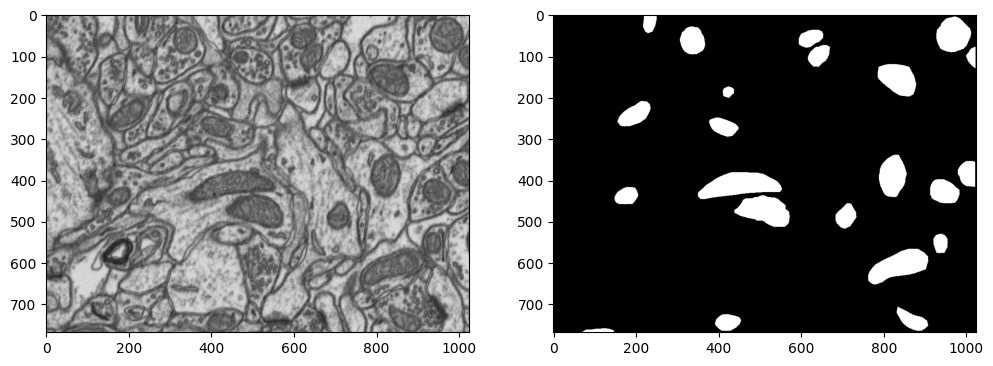

In [15]:
random_index = random.randint(0,image_dataset.shape[0])
random_image = images[random_index]
random_mask = masks[random_index]
display_image(random_image,random_mask)

In [41]:
image_dataset[0].shape

(768, 1024, 1)